# Section 1: Business Understanding

Airbnb is one of the leading online marketplaces for rental vacation homes and condo rentals.

We want to investigate the following business questions for the Australian market:

**Question 1:** What are the most common accommodation amenities?

**Question 2:** Is there a coherence between the number of amenities and prices?

**Question 3:** Is there a coherence between the number of amenities and ratings?

**Question 4:** Is it possible to predict the rating of an Airbnb accommodation?

# Section 2: Data Understanding

First of all we have to import several libraries which will be used in the upcoming analysis.

In [119]:
import ast
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from typing import Dict, List, Tuple

%matplotlib inline

### Gather data

A useful public data source to easily get data from Airbnb is [insideairbnb.com](http://insideairbnb.com/)

The data from Q4-2022 for all Australian cities/regions was downloaded and is provided in the GitHub repository under '/data/listings/'. Each city/region is a separate csv file and all of them have the same column structure.

We read in all the single csv files which are avaiable in the folder and merge them directly.

In [120]:
data_path = "./data/listings/"
data = pd.DataFrame()
for file_name in os.listdir(data_path):
    data = pd.concat([data, pd.read_csv(f"{data_path}{file_name}", sep=",")], ignore_index=True)

### Assess data
To get a better understandig of the data, we start by getting some basic information of the loaded data.

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74938 entries, 0 to 74937
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            74938 non-null  int64  
 1   listing_url                                   74938 non-null  object 
 2   scrape_id                                     74938 non-null  int64  
 3   last_scraped                                  74938 non-null  object 
 4   source                                        74938 non-null  object 
 5   name                                          74929 non-null  object 
 6   description                                   73693 non-null  object 
 7   neighborhood_overview                         45713 non-null  object 
 8   picture_url                                   74938 non-null  object 
 9   host_id                                       74938 non-null 

We have 74938 data rows (accommodations) and 75 columns. There are numeric data as well as string (object) attributes. Several of the columns also have missing values that we have to take care of if we want to use these columns.

There also exists an identifier (id) for each accommodation/room which should be unique but we have to double-check that.

In [122]:
data["id"].duplicated().sum()

79

Unfortunately, there are duplicates. We will drop that later when we prepare our data.

To further decide which data is useful for our analysis, we have a look at some sample data.

In [123]:
pd.set_option('display.max_columns', None)  # show all columns
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4864388,https://www.airbnb.com/rooms/4864388,20220913165628,2022-09-13,city scrape,"Blairgowrie ""Sea La Vie""","With a fresh renovation, situated in a quiet p...",NaN,https://a0.muscache.com/pictures/60994216/5601...,25021534,https://www.airbnb.com/users/show/25021534,Andrew,2014-12-20,NaN,NaN,within a few hours,100%,75%,f,https://a0.muscache.com/im/users/25021534/prof...,https://a0.muscache.com/im/users/25021534/prof...,NaN,1.0,1.0,"['email', 'phone']",t,t,NaN,Point Nepean,NaN,-38.36472,144.78024,Entire home,Entire home/apt,8,NaN,2 baths,3.0,5.0,"[""Central air conditioning"", ""Toaster"", ""Priva...",$213.00,2,1125,2,7,1125,1125,2.4,1125.0,NaN,t,17,47,77,341,2022-09-13,48,5,1,2015-02-19,2022-08-22,4.83,4.87,4.85,4.98,4.94,4.89,4.87,NaN,f,1,1,0,0,0.52
1,228073,https://www.airbnb.com/rooms/228073,20220913165628,2022-09-13,city scrape,The Bud - Beach Cottage,<b>The space</b><br />Beautiful restored 1950'...,NaN,https://a0.muscache.com/pictures/2c1353a7-3aba...,1189726,https://www.airbnb.com/users/show/1189726,Sarah,2011-09-21,"Melbourne, Australia",Sarah T.,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1189726/profi...,https://a0.muscache.com/im/users/1189726/profi...,NaN,1.0,2.0,"['email', 'phone']",t,f,NaN,Rosebud - McCrae,NaN,-38.36228,144.90530,Entire home,Entire home/apt,3,NaN,1.5 baths,2.0,2.0,"[""Shampoo"", ""TV"", ""Wifi"", ""Kitchen"", ""Indoor f...",$600.00,3,7,3,3,7,7,3.0,7.0,NaN,t,28,58,88,363,2022-09-13,3,0,0,2012-02-07,2012-08-02,5.00,4.00,3.50,4.50,5.00,4.50,4.50,NaN,f,1,1,0,0,0.02
2,425004,https://www.airbnb.com/rooms/425004,20220913165628,2022-09-13,city scrape,Sorrento Classic Beach House,<b>The space</b><br />Classic Beach House<br /...,I love that Sorrento has the two coasts to cho...,https://a0.muscache.com/pictures/1e8efd6c-6a7e...,465717,https://www.airbnb.com/users/show/465717,Neil,2011-03-27,"Sorrento, Australia",I have owned the house for over 30 years. Abou...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/465717/profil...,https://a0.muscache.com/im/users/465717/profil...,NaN,1.0,1.0,"['email', 'phone', 'work_email']",t,t,"Sorrento, Victoria, Australia",Point Nepean,NaN,-38.34330,144.74036,Entire home,Entire home/apt,7,NaN,1 bath,3.0,4.0,"[""Lockbox"", ""Private patio or balcony"", ""Fire ...",$300.00,2,365,2,2,365,365,2.0,365.0,NaN,t,22,43,68,303,2022-09-13,249,23,0,2012-05-28,2022-08-13,4.77,4.80,4.58,4.95,4.92,4.91,4.70,NaN,t,1,1,0,0,1.99
3,4882429,https://www.airbnb.com/rooms/4882429,20220913165628,2022-09-13,city scrape,Dromana Family Beach House,"3 Bedrooms (2 x queen, one double and single) ...",NaN,https://a0.muscache.com/pictures/70280c7e-1f4e...,25118777,https://www.airbnb.co

There are several columns which are not helpful for our questions. Instead we can focus on a few of them for the further analysis.

In [124]:
relevant_columns = [
    "accommodates",
    "amenities",
    "bathrooms_text",
    "bedrooms", 
    "beds",
    "host_response_rate",
    "host_response_time",
    "host_is_superhost",
    "neighbourhood_cleansed",
    "number_of_reviews",
    "price",
    "property_type",
    "review_scores_rating",
    "room_type"
]

data[relevant_columns].head()

,accommodates,amenities,bathrooms_text,bedrooms,beds,host_response_rate,host_response_time,host_is_superhost,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_rating,room_type
0,8,"[""Central air conditioning"", ""Toaster"", ""Priva...",2 baths,3.0,5.0,100%,within a few hours,f,Point Nepean,48,$213.00,Entire home,4.83,Entire home/apt
1,3,"[""Shampoo"", ""TV"", ""Wifi"", ""Kitchen"", ""Indoor f...",1.5 baths,2.0,2.0,NaN,NaN,f,Rosebud - McCrae,3,$600.00,Entire home,5.00,Entire home/apt
2,7,"[""Lockbox"", ""Private patio or balcony"", ""Fire ...",1 bath,3.0,4.0,100%,within an hour,t,Point Nepean,249,$300.00,Entire home,4.77,Entire home/apt
3,7,"[""Central air conditioning"", ""Lockbox"", ""Priva...",1 bath,3.0,5.0,100%,within an hour,f,Dromana,165,$250.00,Entire home,4.63,Entire home/apt
4,2,"[""Central air conditioning"", ""Toaster"", ""Priva...",1 bath,1.0,4.0,100%,within an hour,f,Point Nepean,170,$197.00,Entire guest suite,4.86,Entire home/apt


We will now have a closer look at the data types.

In [125]:
data["amenities"]

0        ["Central air conditioning", "Toaster", "Priva...
1        ["Shampoo", "TV", "Wifi", "Kitchen", "Indoor f...
2        ["Lockbox", "Private patio or balcony", "Fire ...
3        ["Central air conditioning", "Lockbox", "Priva...
4        ["Central air conditioning", "Toaster", "Priva...
                               ...                        
74933    ["Dedicated workspace", "Washer", "Freezer", "...
74934                  ["Long term stays allowed", "Pool"]
74935    ["Washer", "Freezer", "Smoke alarm", "Kitchen"...
74936    ["Washer", "Freezer", "Rice maker", "Smoke ala...
74937    ["Washer", "Wifi", "Air conditioning", "Free p...
Name: amenities, Length: 74938, dtype: object

The amenities data are provided in a list-like format as a string. We have to convert that to a list and split the data later to  work with it properly.

In [126]:
data["host_response_rate"]

0        100%
1         NaN
2        100%
3        100%
4        100%
         ... 
74933    100%
74934     NaN
74935     94%
74936     98%
74937    100%
Name: host_response_rate, Length: 74938, dtype: object

The host response rate is a percentage value but not a numeric value yet.

In [127]:
data["price"]

0        $213.00
1        $600.00
2        $300.00
3        $250.00
4        $197.00
          ...   
74933    $165.00
74934    $388.00
74935    $208.00
74936    $470.00
74937    $450.00
Name: price, Length: 74938, dtype: object

The price is also a string but should be converted to a float.

The data types of the other columns look appropriate.

There are some missing values which we could see here:

In [128]:
data[relevant_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74938 entries, 0 to 74937
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            74938 non-null  int64  
 1   amenities               74938 non-null  object 
 2   bathrooms_text          74884 non-null  object 
 3   bedrooms                71727 non-null  float64
 4   beds                    73980 non-null  float64
 5   host_response_rate      51398 non-null  object 
 6   host_response_time      51398 non-null  object 
 7   host_is_superhost       74886 non-null  object 
 8   neighbourhood_cleansed  74938 non-null  object 
 9   number_of_reviews       74938 non-null  int64  
 10  price                   74938 non-null  object 
 11  property_type           74938 non-null  object 
 12  review_scores_rating    61677 non-null  float64
 13  room_type               74938 non-null  object 
dtypes: float64(3), int64(2), object(9)
mem

For the first two questions (1+2) we won't have to deal with null values. (amenities count, price)

For the last two questions (3+4) we have to consider that some accommodations have no rating yet.

For the last question (4), where we will build a model, there are various columns with missing values that we have to take care of.


Now we will look for outliers:

In [129]:
data[relevant_columns].describe()

,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating
count,74938.000000,71727.000000,73980.000000,74938.000000,61677.000000
mean,4.407417,2.109066,2.727021,36.121207,4.663244
std,2.788223,1.275121,2.038963,67.647193,0.689833
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,4.640000
50%,4.000000,2.000000,2.000000,9.000000,4.850000
75%,6.000000,3.000000,4.000000,40.000000,4.990000
max,16.000000,50.000000,49.000000,949.000000,5.000000


The ratings seems to be very high, even the 25th percentile have a rating of 4.64 of 5. A histogram of the data will show it even better:

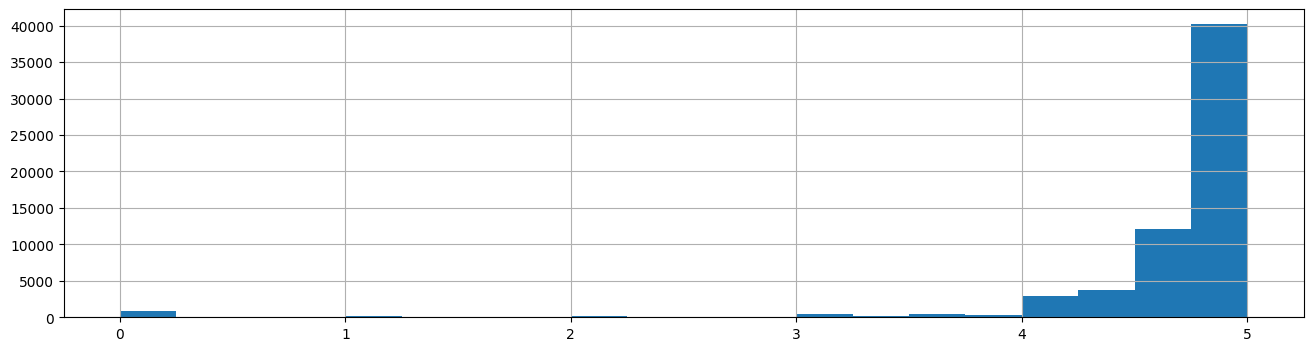

In [130]:
data["review_scores_rating"].hist(figsize=(16,4), bins=20);

There is no error in the data, but we should be aware that the valuation data is very left-skewed.

The max value of the bedrooms looks also a bit unusual. We can select that accomodation:

In [131]:
data[data["bedrooms"] == 50]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
39916,19642549,https://www.airbnb.com/rooms/19642549,20220920074549,2022-09-20,city scrape,Dandaragan Moora Public Accommodation Village,Redgum Village has 62 ensuite bedrooms and mea...,Once again being a small town the locals take ...,https://a0.muscache.com/pictures/89544f18-8c2e...,105082268,https://www.airbnb.com/users/show/105082268,Evan And Gaylene,2016-11-25,"Dandaragan, Australia",Evan and Gaylene are married and blessed with ...,within a day,100%,50%,f,https://a0.muscache.com/im/pictures/user/5e2d8...,https://a0.muscache.com/im/pictures/user/5e2d8...,NaN,1.0,2.0,"['email', 'phone', 'work_email']",t,t,"Dandaragan, Western Australia, Australia",DANDARAGAN,NaN,-30.67852,115.7031,Private room,Private room,16,NaN,0 shared baths,50.0,49.0,"[""Smoke alarm"", ""EV charger"", ""Bed linens"", ""P...",$120.00,1,90,1,1,90,90,1.0,90.0,NaN,t,27,57,87,87,2022-09-20,5,1,0,2018-02-24,2021-09-27,5.0,4.8,4.8,4.8,5.0,4.8,4.2,NaN,f,1,0,1,0,0.09


We can view that url on Airbnb. It looks like a large facility, so the data also seems to be correct.

The describe function from pandas only can consider numeric values. We have to take a look at the outliers for the price after we transformed the data in the next section.

# Section 3: Data Preparation

#### Drop duplicated identifier
We have discovered before that the data contains duplicated identifier. Let's drop them and keep that record with the latest scrape date. 

In [132]:
data.sort_values(by="last_scraped", ascending=False, inplace=True)
data.drop_duplicates(subset=["id"], keep="first", ignore_index=True, inplace=True)

#### Remove expendable columns
We can filter the data to the relevant columns that we determined in the previous section.

In [133]:
data = data[relevant_columns]

#### Convert string values into numeric amounts
We also uncovered that the price and host response rate should be numeric values instead of strings. We will now convert them.

In [134]:
data["price_amount"] = [float(price_str[1:].replace(",", "")) for price_str in data["price"]]

data["host_response_rate"] = [
    int(response_rate.replace("%", "")) if pd.notnull(response_rate) else np.NaN
    for response_rate in data["host_response_rate"]
]

#### Remove price outliers
After we converted the price to a numeric value, we can look for possible outliers.

In [135]:
data["price_amount"].describe()

count     74859.00000
mean        303.86096
std         810.91171
min           0.00000
25%         115.00000
50%         190.00000
75%         329.50000
max      126999.00000
Name: price_amount, dtype: float64

There are obviously some price errors. Hence we will drop records with a price lower than 10 or higher than 5000.

In [136]:
data = data[(data["price_amount"] > 10) & (data["price_amount"] < 5000)]

#### Convert list-like string amenities into real lists
The list-like string with the amenities will be converted to a real list data type.

In [137]:
data["amenities"] = [ast.literal_eval(amenities) for amenities in data["amenities"]]

Unfortunately the single amenity values are only partly standardized. Here is a sample with short values that contains "conditioner":

In [138]:
{amenity for amenities in data["amenities"] for amenity in amenities if "conditioner" in amenity.lower() and len(amenity) < 15}

{'- conditioner',
 '.  conditioner',
 '. conditioner',
 '.. conditioner',
 'Conditioner',
 'N conditioner',
 'NA conditioner',
 'OC conditioner',
 'P conditioner',
 'X conditioner'}

#### Normalize amenity values
Therefore we have to normalize the amenity values to improve the data quality because there are not fully standardized.

In [139]:
def normalize_amenity(amenity: str) -> str:
    """
    Normalize an amenity value for a better standardization.
    
    :param amenity: amenity string value that will be normalized
    :return: normalized amenity value
    """
    amenity = amenity.lower()
    amenity = amenity.replace("-", " ")
    amenity = re.sub(r"[^\w\s]", " ", amenity)
    amenity = re.sub(r"[\s]{2,}", " ", amenity)
    amenity = amenity.strip()
    return amenity

data["amenities"] = [[normalize_amenity(amenity) for amenity in amenities] for amenities in data["amenities"]]

#### Count total occurrences of each amenity
To analyse the most common amenities in question 1 we need to prepare a total count per amenity.

In [140]:
def count_occurrences_of_amenities(amenities: pd.Series) -> Counter:
    """
    Count all occurences of each amenity.
    
    :param amenities: amenities data from all acommodations
    :return: total count per amenity
    """
    total_amenity_values = itertools.chain(*amenities)
    return Counter(total_amenity_values)

total_count_per_amenity = count_occurrences_of_amenities(data["amenities"])

#### Count amenties per accommodation
We need the count of amenities per accommodation as well.

In [141]:
data["amenities_count"] = [len(amenities) for amenities in data["amenities"]]

#### Consider only meaningful ratings
For question 3 and 4 we only want to consider ratings with at least five reviews. Otherwise we assume that the rating value is not meaningful enough for our analysis.

In [142]:
data["rating_with_min_5_reviews"] = [
    rating if review_count >= 5 else np.NaN
    for rating, review_count in zip(data["review_scores_rating"], data["number_of_reviews"])
]

# data with min 5 reviews will be abbreviated with data_m5r
data_m5r = data[data["rating_with_min_5_reviews"].notnull() & data["rating_with_min_5_reviews"] > 0].copy().reset_index(drop=True)

#### Determine data for the rating model
The following data columns will be used in our model in question 4. To further prepare them we need to separate them by data type.

In [143]:
numeric_rating_prediction_columns = [
    "host_response_rate",
    "accommodates",
    "bedrooms", 
    "beds",
    "price_amount",
    "amenities_count"
]

categorical_rating_prediction_columns = [
    "host_response_time",
    "host_is_superhost",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "bathrooms_text"
]

#### Impute missing numeric data
We calculate the column mean for all missing numeric values that we want to use for the model. In this case it regards beds, bedrooms and host response rate and its appropriate instead of dropping the regarding rows or columns.

In [145]:
data_m5r[numeric_rating_prediction_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45133 entries, 0 to 45132
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   host_response_rate  36279 non-null  float64
 1   accommodates        45133 non-null  int64  
 2   bedrooms            42996 non-null  float64
 3   beds                44756 non-null  float64
 4   price_amount        45133 non-null  float64
 5   amenities_count     45133 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 2.1 MB


In [ ]:
def impute_missing_numeric_data(data: pd.DataFrame, numeric_cols: List[str]) -> pd.DataFrame:
    """
    Fill null values of numeric attributes with the mean of the entire column.
    
    :param data: data for the rating model
    :param numeric_cols: numeric columns whose missing values will be replaced
    :return: data for the rating model without missing numeric values
    """    
    for numeric_col in numeric_cols:
        data[numeric_col] = data[numeric_col].fillna(data[numeric_col].mean())
        
    return data


data_m5r = impute_missing_numeric_data(data_m5r, numeric_rating_prediction_columns)

#### Convert amenities data into dummies

In [ ]:
def remove_unusual_amenities(total_count_per_amenity: Counter, min_amenity_count: int) -> Dict[str, int]:
    """
    Remove unusual amenities based on their total number of occurrences.
    
    :param total_count_per_amenity: all amenities with their total number of occurrences
    :param min_amenity_count: minimum occurences to remain in the data
    :return: total count per amenity for all usual amenities
    """
    origin_total_amenity_keys = len(total_count_per_amenity.keys())
    origin_total_amenity_values = sum(total_count_per_amenity.values())
    
    total_count_per_amenity = {
        amenity: amenity_count for (amenity, amenity_count) in total_count_per_amenity.items()
        if amenity_count >= min_amenity_count
    }

    print(f"Removed {round(abs(len(total_count_per_amenity.keys()) / origin_total_amenity_keys - 1) * 100, 1)}% amenity keys "
          f"but only {round(abs(sum(total_count_per_amenity.values()) / origin_total_amenity_values - 1) * 100, 1)}% of the set amenity values in total.")
    
    return total_count_per_amenity


def convert_amenities_data_into_dummies(data: pd.DataFrame, min_amenity_count: int) -> pd.DataFrame:
    """
    Convert the list of amenities for each accommodation into dummy variables.
    
    :param data: data for the rating model
    :param min_amenity_count: minimum occurences to remain in the data
    :return: data for the rating model with dummies for the amenity data
    """
    total_count_per_amenity = Counter(itertools.chain(*data["amenities"]))

    total_count_per_amenity = remove_unusual_amenities(total_count_per_amenity, min_amenity_count)
    
    amenity_dummies = pd.concat(
        [pd.Series(name=f"amenity_{amenity.replace(' ', '_')}",
                   data=[1 if amenity in accomodation_amenities else 0 for accomodation_amenities in data["amenities"]]) 
         for amenity in total_count_per_amenity.keys()], axis=1
    )
    
    data = pd.concat([data.drop(columns=["amenities"]), amenity_dummies], axis=1)

    return data


data_m5r = convert_amenities_data_into_dummies(data_m5r, min_amenity_count=200)

#### Convert other categorical data into dummies

In [ ]:
def convert_other_categorical_data_into_dummies(data: pd.DataFrame, categorical_cols: List[str]) -> pd.DataFrame:
    """
    Convert categorical attributes into dummy variables.
    
    :param data: data for the rating model
    :param categorical_cols: categorical columns that will be converted
    :return: data for the rating model with dummy variables for categorical data columns
    """
    data = pd.get_dummies(data, prefix=categorical_cols, columns=categorical_cols, dummy_na=False, drop_first=False)
    return data
    
    
data_m5r = convert_other_categorical_data_into_dummies(data_m5r, categorical_rating_prediction_columns)

#### Cutoff categorical data with almost only zero values to avoid overfitting

In [ ]:
def cutoff_categorical_data_with_almost_only_zero_values(
    data: pd.DataFrame, categorical_cols: List[str], cutoff: int
) -> pd.DataFrame:
    """
    Remove dummy variables that have almost only zero values to avoid overfitting.
    
    :param data: data for the rating model
    :param categorical_cols: categorical columns that will be converted
    :param cutoff: minimum threshold of 1-values to remain in the data
    :return: data for the rating model without dummy variables that are almost only zero
    """
    cutoff_cols = []
        
    for cat_col in categorical_cols:
        cat_col_dummies = data.columns[data.columns.str.startswith(f"{cat_col}_")]
        for cat_col_dummy in cat_col_dummies:
            if data[cat_col_dummy].sum() <= cutoff:
                cutoff_cols.append(cat_col_dummy)
                
    data = data.drop(columns=cutoff_cols).reset_index(drop=True)
    
    return data


data_m5r = cutoff_categorical_data_with_almost_only_zero_values(data_m5r, categorical_rating_prediction_columns + ["amenity"], cutoff=50)

# Section 4: Modeling

## Question 1:  What are the most common accommodation amenities?

#### Select the Top 20 amenties and calculate their relative share on all accommodations

In [36]:
top20_amenities = dict(sorted(total_count_per_amenity.items(), key=lambda x:x[1], reverse=True)[:20])
top20_values_in_percent = [round(value / len(data) * 100) for value in top20_amenities.values()]

#### Plot Top 20 amenities as horizontal barchart

In [ ]:
plt.figure(figsize=(13, 7))
plt.xticks(range(0,100,10))
sns.barplot(x=top20_values_in_percent, y=list(top20_amenities.keys()), color = "cornflowerblue");

**Answer:** There are five amenities that are present in 4 out of 5 accomodations: kitchen, smoke alarm, long term stays allowed, essentials and wifi. Over 90% of the australian accommodations have a kitchen, which is the most common amenity.

## 2 - Is there a coherence between the number of amenities and prices?

#### Build a scatterplot between the number of amenities and price 

In [ ]:
plt.figure(figsize=(16, 10))
plt.xlim(0,1000)
plt.ylim(0,80)
plt.xlabel('acommodation price')
plt.ylabel('number of amenities')
sns.scatterplot(y=data["amenities_count"], x=data["price_amount"], color = "cornflowerblue", alpha=0.05);

#### Calculate the correlation

In [ ]:
print(f"correlation: {round(data['amenities_count'].corr(data['price_amount']), 3)}")

**Answer:** There is a very weak correlation between the price and the number of amenities. The scatter plot with nearly equally distributed dots over the entire price axes also emphasizes that there is no coherence.

## 3 - Is there a coherence between the number of amenities and ratings?

#### Build a scatterplot between the number of amenities and ratings

In [ ]:
plt.figure(figsize=(16, 10))
plt.xticks(range(3,5,1))
plt.xlim(3,5)
plt.ylim(0,80)
plt.xlabel('acommodation rating')
plt.ylabel('number of amenities')
sns.scatterplot(y=data_m5r["amenities_count"], x=data_m5r["rating_with_min_5_reviews"], color = "cornflowerblue", alpha=0.15);

*Note: Most of the ratings are between 3 and 5 which is why the axis is scaled to that range.*

#### Calculate the correlation

In [ ]:
print(f"correlation: {round(data_m5r['amenities_count'].corr(data_m5r['rating_with_min_5_reviews']), 3)}")

**Answer:** There is at least a low correlation between the rating values and the number of amenities. The scatterplot also shows, that the ratings tends to be a bit higher, the more amenties an accommodation have.

## 4 - Is it possible to predict the rating of an australian airbnb accommodation?

In [ ]:
response_variable = "rating_with_min_5_reviews"

data_m5r = data_m5r[
    [response_variable]
    + numeric_rating_prediction_columns
    + categorical_rating_prediction_columns
    + ["amenities"]
]

#### Split data into test/train and build linear regression model

In [ ]:
def build_linear_model(
    X: pd.DataFrame, y: pd.Series, test_size: float = .3, rand_state: int = 42
) -> Tuple[Pipeline, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split data into train/test and create a linear regression model.
    
    :param X: model input data
    :param y: response variable
    :param test_size: proportion of test data
    :param rand_state: random state for splitting the data into training and test
    :return:
        - model: built linear regression model
        - X_train: train input data of the model
        - X_test: test input data of the model
        - y_train: response variable of the train data
        - y_test: response variable of the test data
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
    model.fit(X_train, y_train)
        
    return model, X_train, X_test, y_train, y_test


model, X_train, X_test, y_train, y_test = build_linear_model(data_m5r.drop(columns=[response_variable]), data_m5r[response_variable])

#### Predict rating for test/train data and calculate r2 score

In [ ]:
def predict_rating(model: Pipeline, X: pd.DataFrame, y: pd.Series) -> Tuple[np.ndarray, np.float64]:
    """
    Predict the accommodation ratings and calculate the correspending r2 score.
    
    :param model: model to predict accommodation ratings
    :param X: model input data
    :param y: rating response variable
    :return:
        - y_predicted: predicted accommodation ratings
        - score: r2 score of the predicted ratings
    """
    y_predicted = model.predict(X)
    score = r2_score(y, y_predicted)
    
    return y_predicted, score


y_train_predicted, y_train_score = predict_rating(model, X_train, y_train)
y_test_predicted, y_test_score = predict_rating(model, X_test, y_test)

print(f"The r2 scores of the predicted ratings are {round(y_train_score, 3)} (train) and {round(y_test_score, 3)} (test).")

#### Show the most influential coefficients of the built model

In [ ]:
def get_coefficients_weights(coefficients: np.ndarray, X_train: pd.DataFrame) -> pd.DataFrame:
    """
    Show the most influential coefficients of the linear regression model.
    
    :param coefficients: coefficients of the model
    :param X_train: input train data of the model
    :return: coefficients of the model sorted by their amount
    """
    coefs_df = pd.DataFrame()
    coefs_df['variable'] = X_train.columns
    coefs_df['coefficient'] = coefficients
    coefs_df['coefficient_abs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('coefficient_abs', ascending=False)
    return coefs_df

model_coefficients = get_coefficients_weights(model.named_steps["linearregression"].coef_, X_train)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

model_coefficients[['variable', 'coefficient']].head(10)

**Answer:** A roughly prediction of an airbnb accommodation rating is possible with the publicly available data from airbnb. However, with more internal data from airbnb it would probably be possible to increase the precision of the model.

The most influential coefficients of this trained model are the room types.